# Bayesian Modelling Examples

# PyMC - Example

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax

In [2]:
# Enable GPU (?)
jax.config.update("jax_enable_x64", True)

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

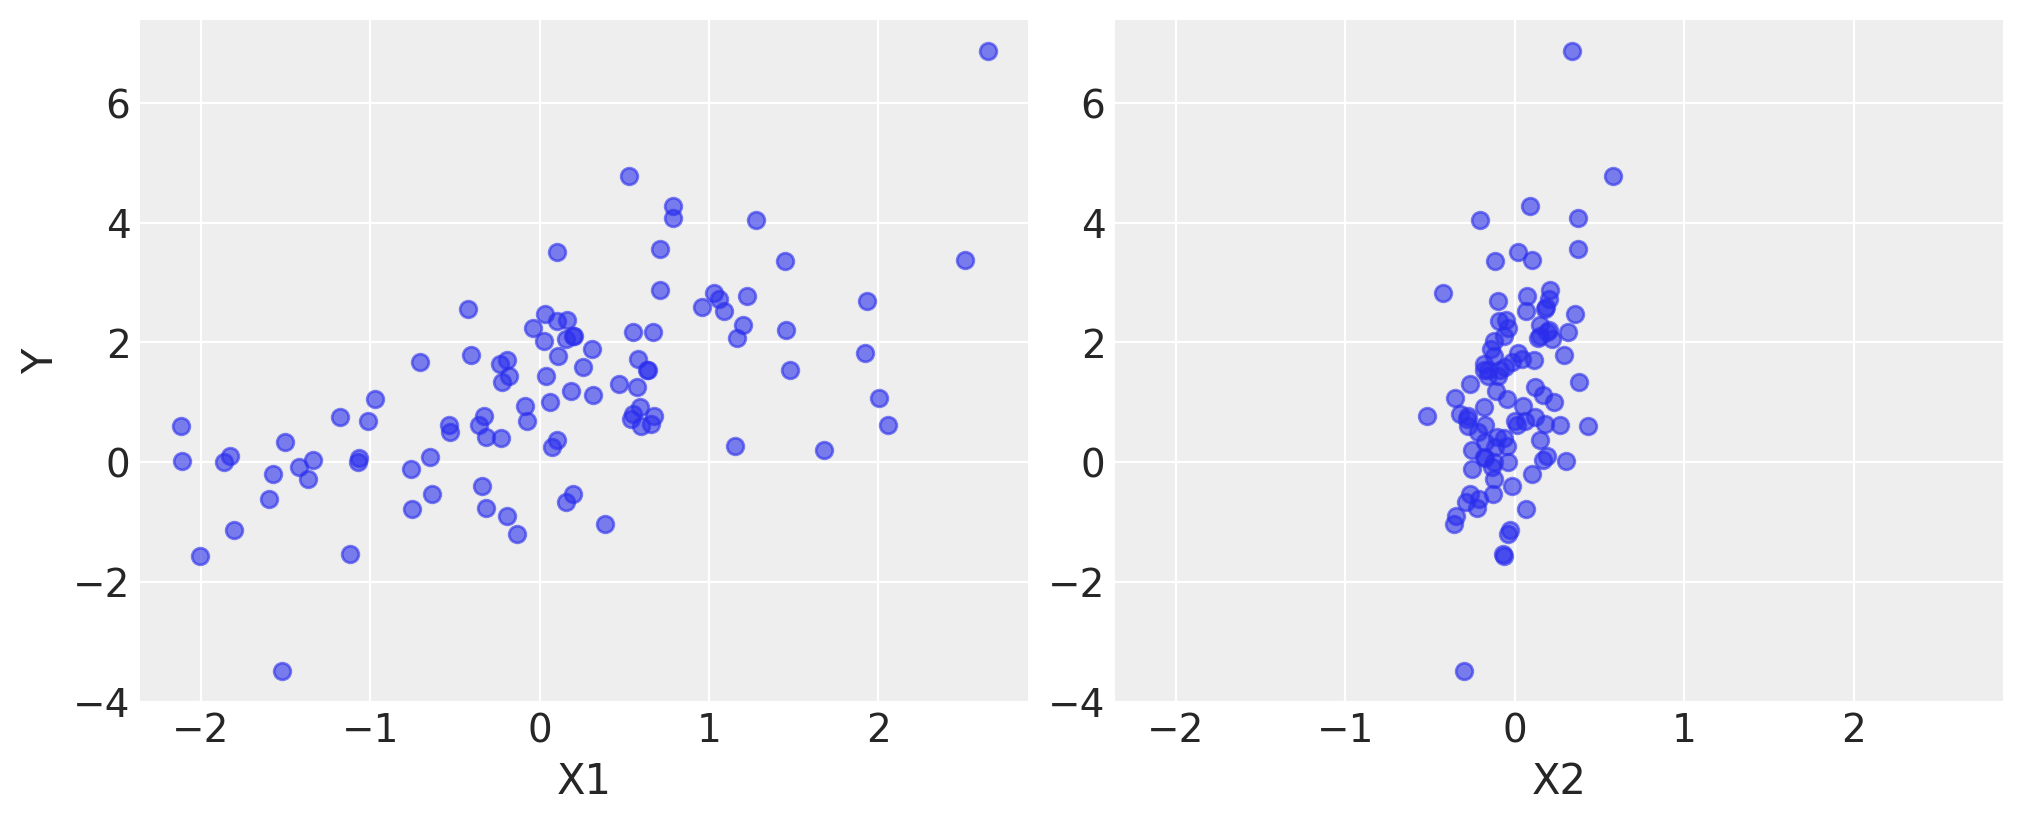

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [6]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.15.0


In [7]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [8]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(nuts_sampler='nutpie')

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.22870692, 1.05688146, 1.05670809, 1.20553707, 1.34382125],
       [1.15312188, 1.26763161, 1.24800751, 1.10460451, 1.21719373],
       [1.28798901, 1.25585629, 0.93433012, 1.17720079, 1.02695118],
       [1.24612105, 1.10312793, 1.21093867, 1.16554653, 1.20490282]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

In [10]:
# with basic_model:
#     # instantiate sampler
#     step = pm.Slice()

#     # draw 5000 posterior samples
#     slice_idata = pm.sample(5000, step=step)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'sigma_log__'}>,
        <Axes: title={'center': 'sigma_log__'}>]], dtype=object)

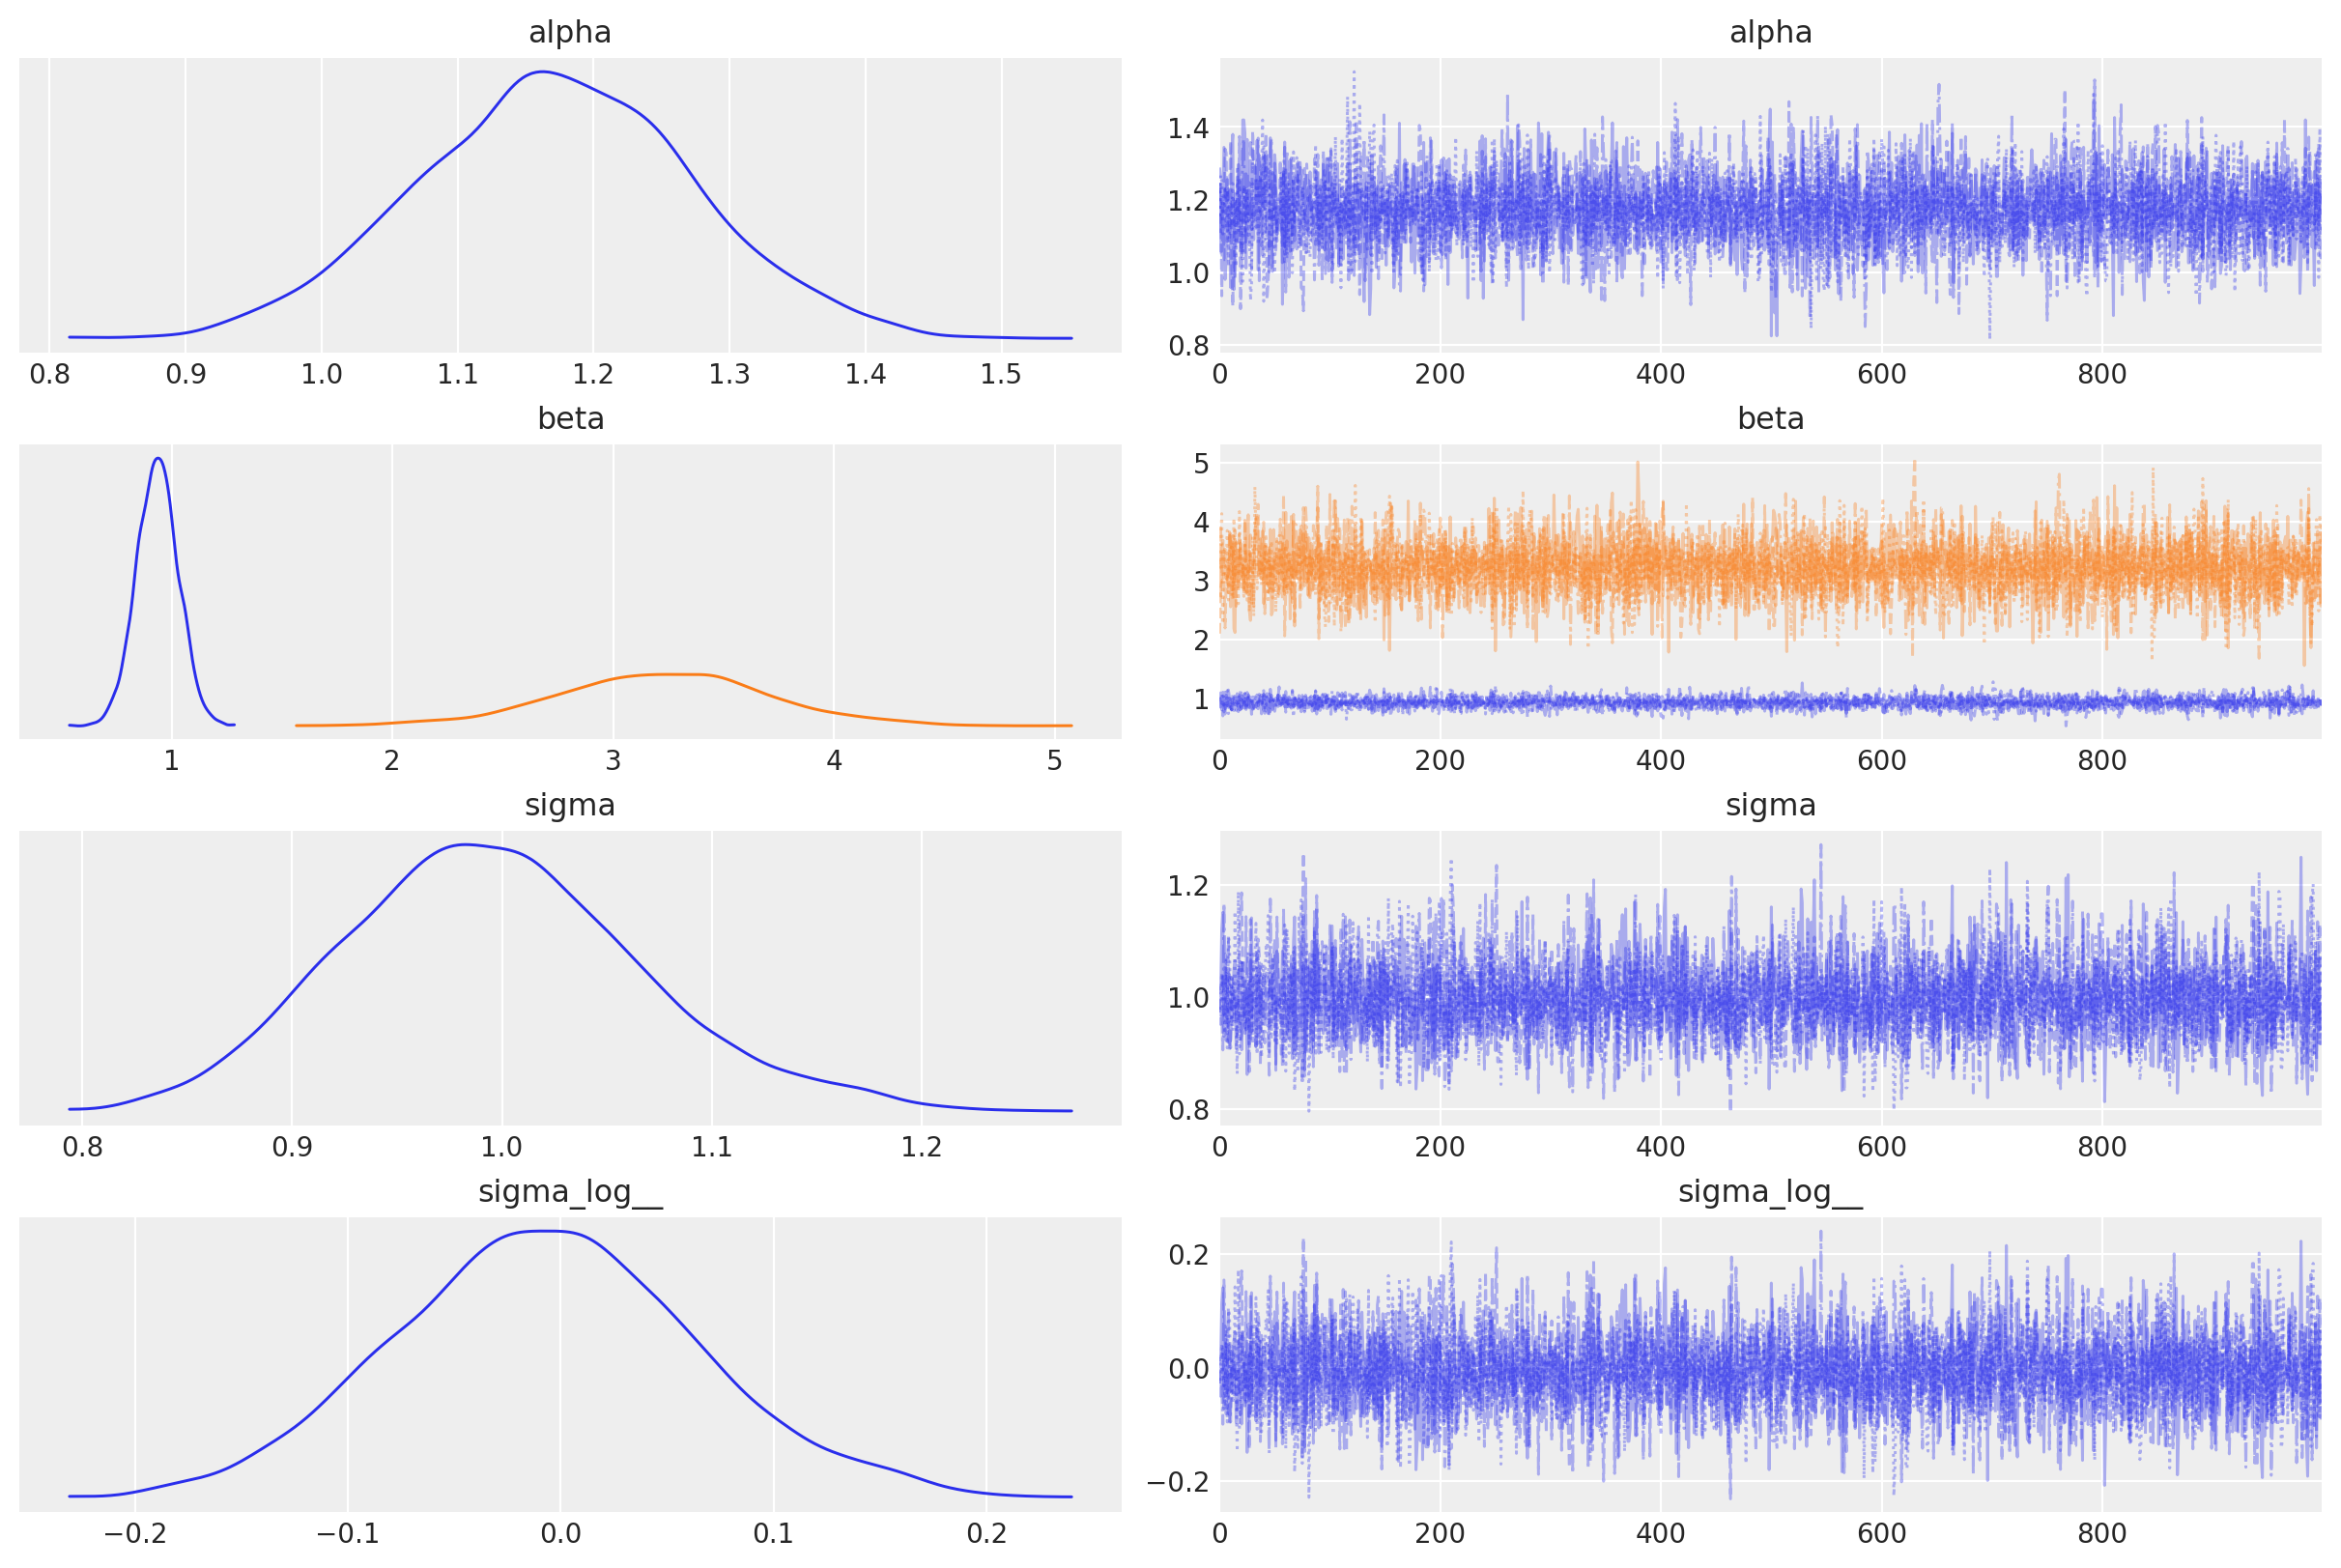

In [11]:
az.plot_trace(idata, combined=True)

In [12]:
az.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha        1.17  0.10    0.98     1.37       0.00      0.0   6270.21   
beta[0]      0.94  0.09    0.76     1.11       0.00      0.0   6169.43   
beta[1]      3.23  0.48    2.34     4.18       0.01      0.0   6154.89   
sigma        1.00  0.07    0.86     1.13       0.00      0.0   5945.63   
sigma_log__ -0.01  0.07   -0.14     0.13       0.00      0.0   5945.63   

             ess_tail  r_hat  
alpha         3116.17    1.0  
beta[0]       3446.94    1.0  
beta[1]       3305.84    1.0  
sigma         3155.69    1.0  
sigma_log__   3155.69    1.0

# Example: Hierachical Model

- Example using bambi

In [13]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xarray as xr

In [14]:
az.style.use("arviz-darkgrid")
SEED = 7355608

In [15]:
import requests
import pandas as pd
import statsmodels.api as sm
from io import StringIO

# URL to the dataset
url = "https://vincentarelbundock.github.io/Rdatasets/csv/geepack/dietox.csv"

# Download the dataset using requests
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))

# Display dataset description
data.describe()


rownames          Pig      Litter       Start      Weight  \
count  861.000000   861.000000  861.000000  861.000000  861.000000   
mean   431.000000  6238.319396   12.135889   25.672701   60.725769   
std    248.693587  1323.845928    7.427252    3.624336   24.978881   
min      1.000000  4601.000000    1.000000   15.000000   15.000000   
25%    216.000000  4857.000000    5.000000   23.799990   38.299990   
50%    431.000000  5866.000000   11.000000   25.700000   59.199980   
75%    646.000000  8050.000000   20.000000   27.299990   81.199950   
max    861.000000  8442.000000   24.000000   35.399990  117.000000   

             Feed        Time  
count  789.000000  861.000000  
mean    80.728645    6.480836  
std     52.877736    3.444735  
min      3.300003    1.000000  
25%     32.800003    3.000000  
50%     74.499996    6.000000  
75%    123.000000    9.000000  
max    224.500000   12.000000

In [16]:
data

rownames   Pig     Evit     Cu  Litter  Start     Weight        Feed  \
0           1  4601  Evit000  Cu000       1   26.5   26.50000         NaN   
1           2  4601  Evit000  Cu000       1   26.5   27.59999    5.200005   
2           3  4601  Evit000  Cu000       1   26.5   36.50000   17.600000   
3           4  4601  Evit000  Cu000       1   26.5   40.29999   28.500000   
4           5  4601  Evit000  Cu000       1   26.5   49.09998   45.200001   
..        ...   ...      ...    ...     ...    ...        ...         ...   
856       857  8442  Evit000  Cu175      24   25.7   73.19995   83.800003   
857       858  8442  Evit000  Cu175      24   25.7   81.69995   99.800003   
858       859  8442  Evit000  Cu175      24   25.7   90.29999  115.200001   
859       860  8442  Evit000  Cu175      24   25.7   96.00000  133.200001   
860       861  8442  Evit000  Cu175      24   25.7  103.50000  151.400002   

     Time  
0       1  
1       2  
2       3  
3       4  
4       5  
..    ...  
856     8  
857     9  
858    10  
859    11  
860    12  

[861 rows x 9 columns]

In [17]:
model = bmb.Model("Weight ~ Time + (Time|Pig)", data)
results = model.fit(nuts_sampler='nutpie')

In [18]:
model

       Formula: Weight ~ Time + (Time|Pig)
        Family: gaussian
          Link: mu = identity
  Observations: 861
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 60.7258, sigma: 133.0346)
            Time ~ Normal(mu: 0.0, sigma: 18.1283)
        
        Group-level effects
            1|Pig ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 133.0346))
            Time|Pig ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 18.1283))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 24.9644)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [1|Pig_sigma, Intercept, Time, Time|Pig_sigma, Weight_sigma]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Weight_sigma'}>,
        <Axes: title={'center': 'Time'}>],
       [<Axes: title={'center': '1|Pig_sigma'}>,
        <Axes: title={'center': 'Time|Pig_sigma'}>, <Axes: >]],
      dtype=object)

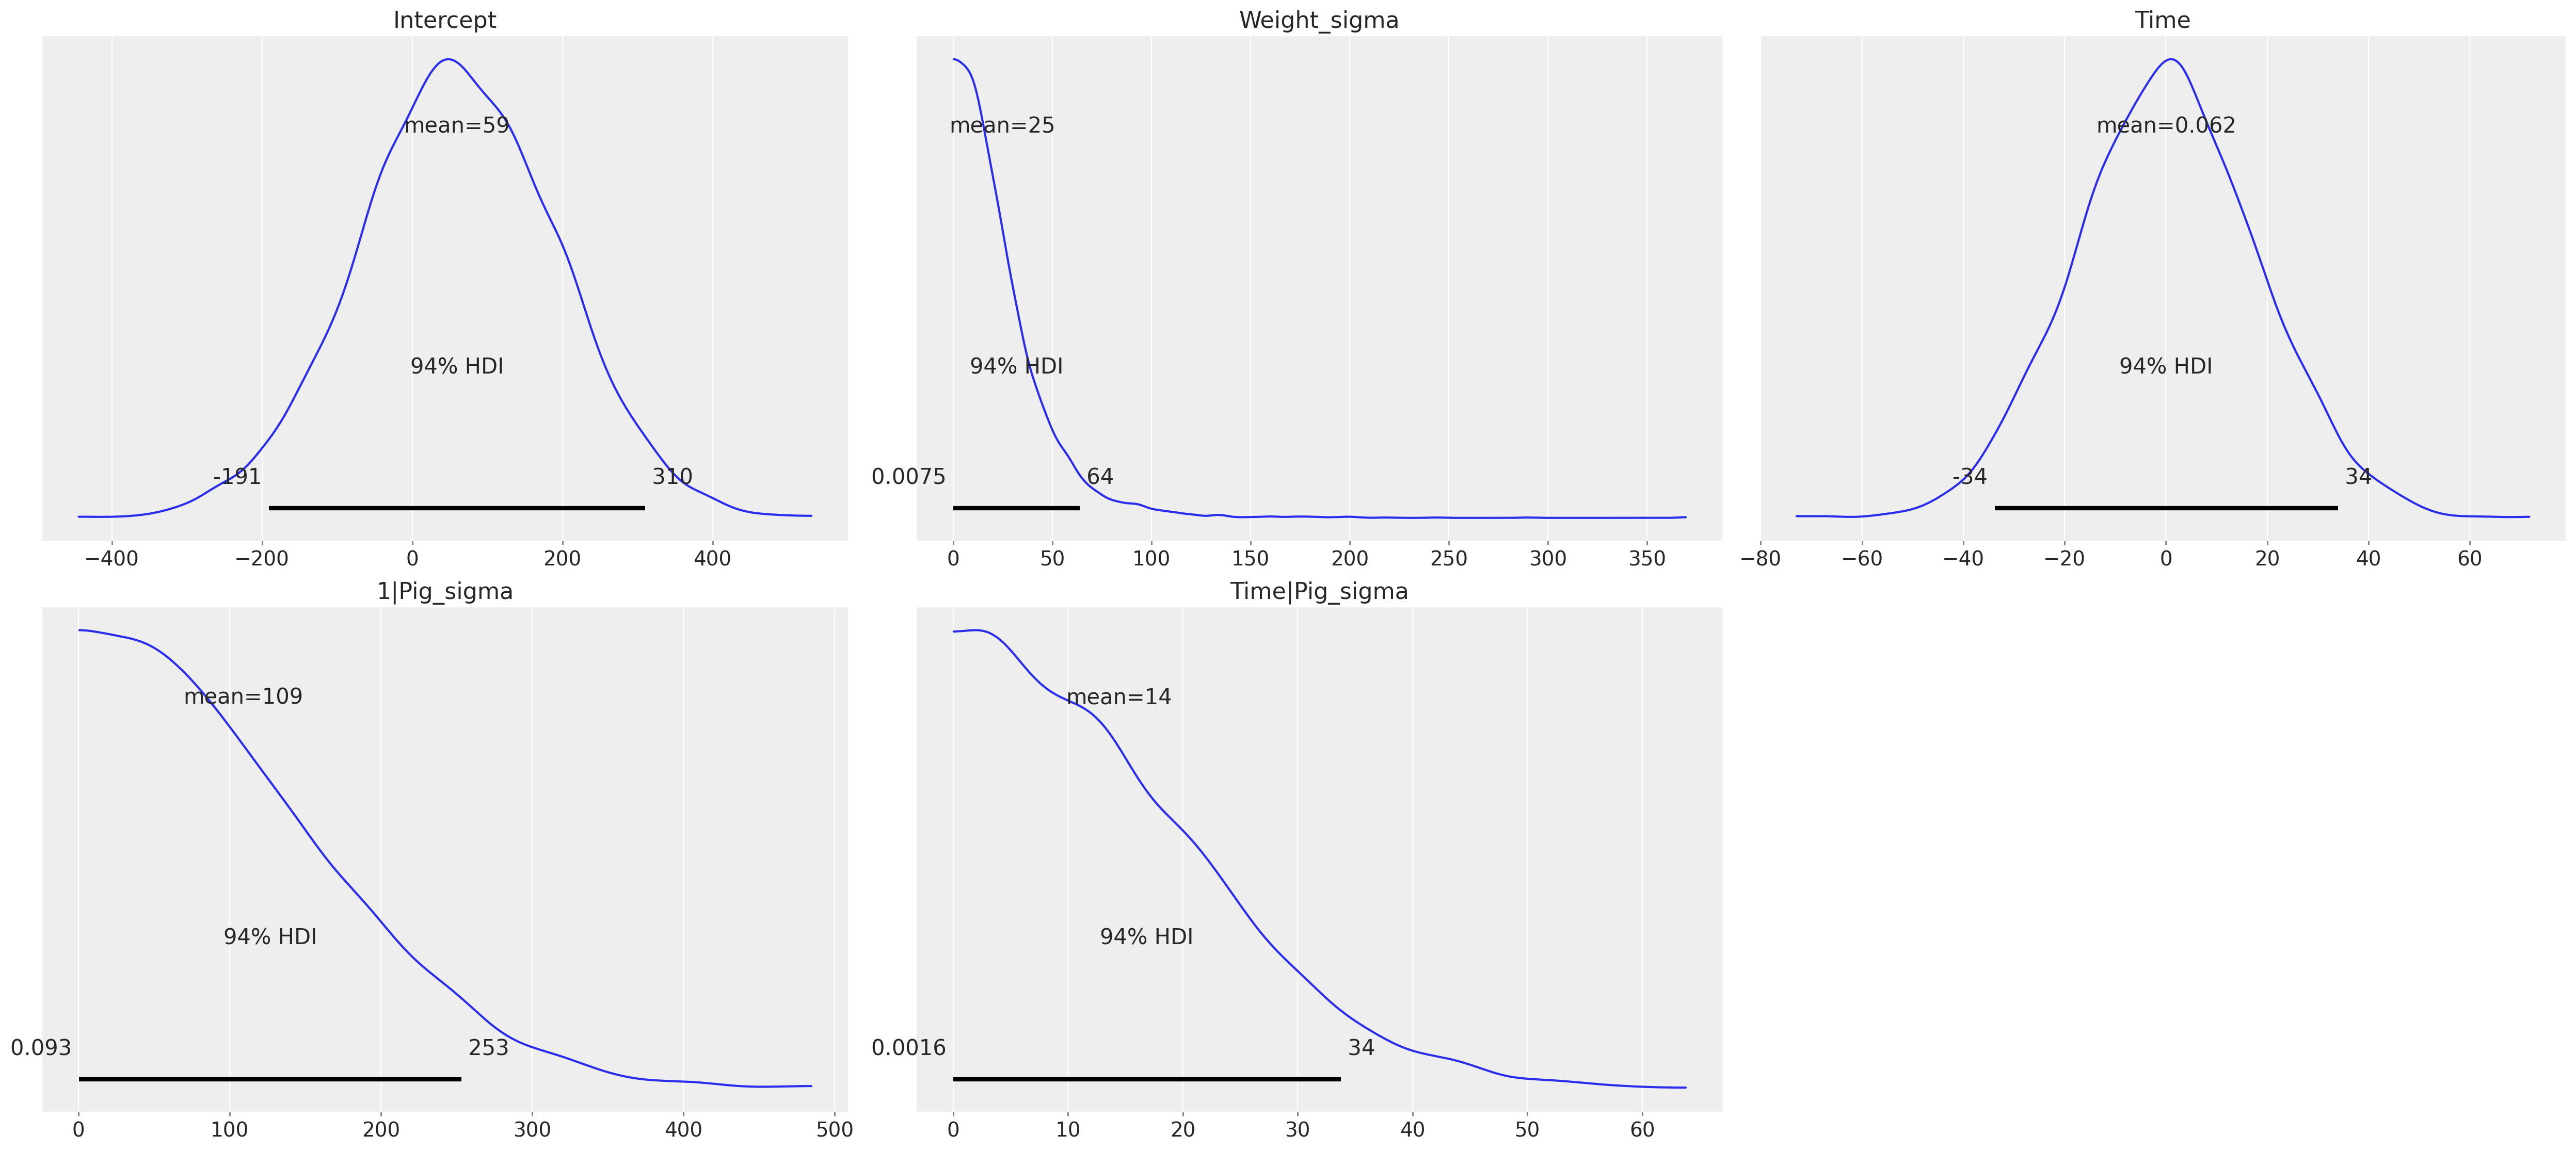

In [20]:
model.plot_priors()

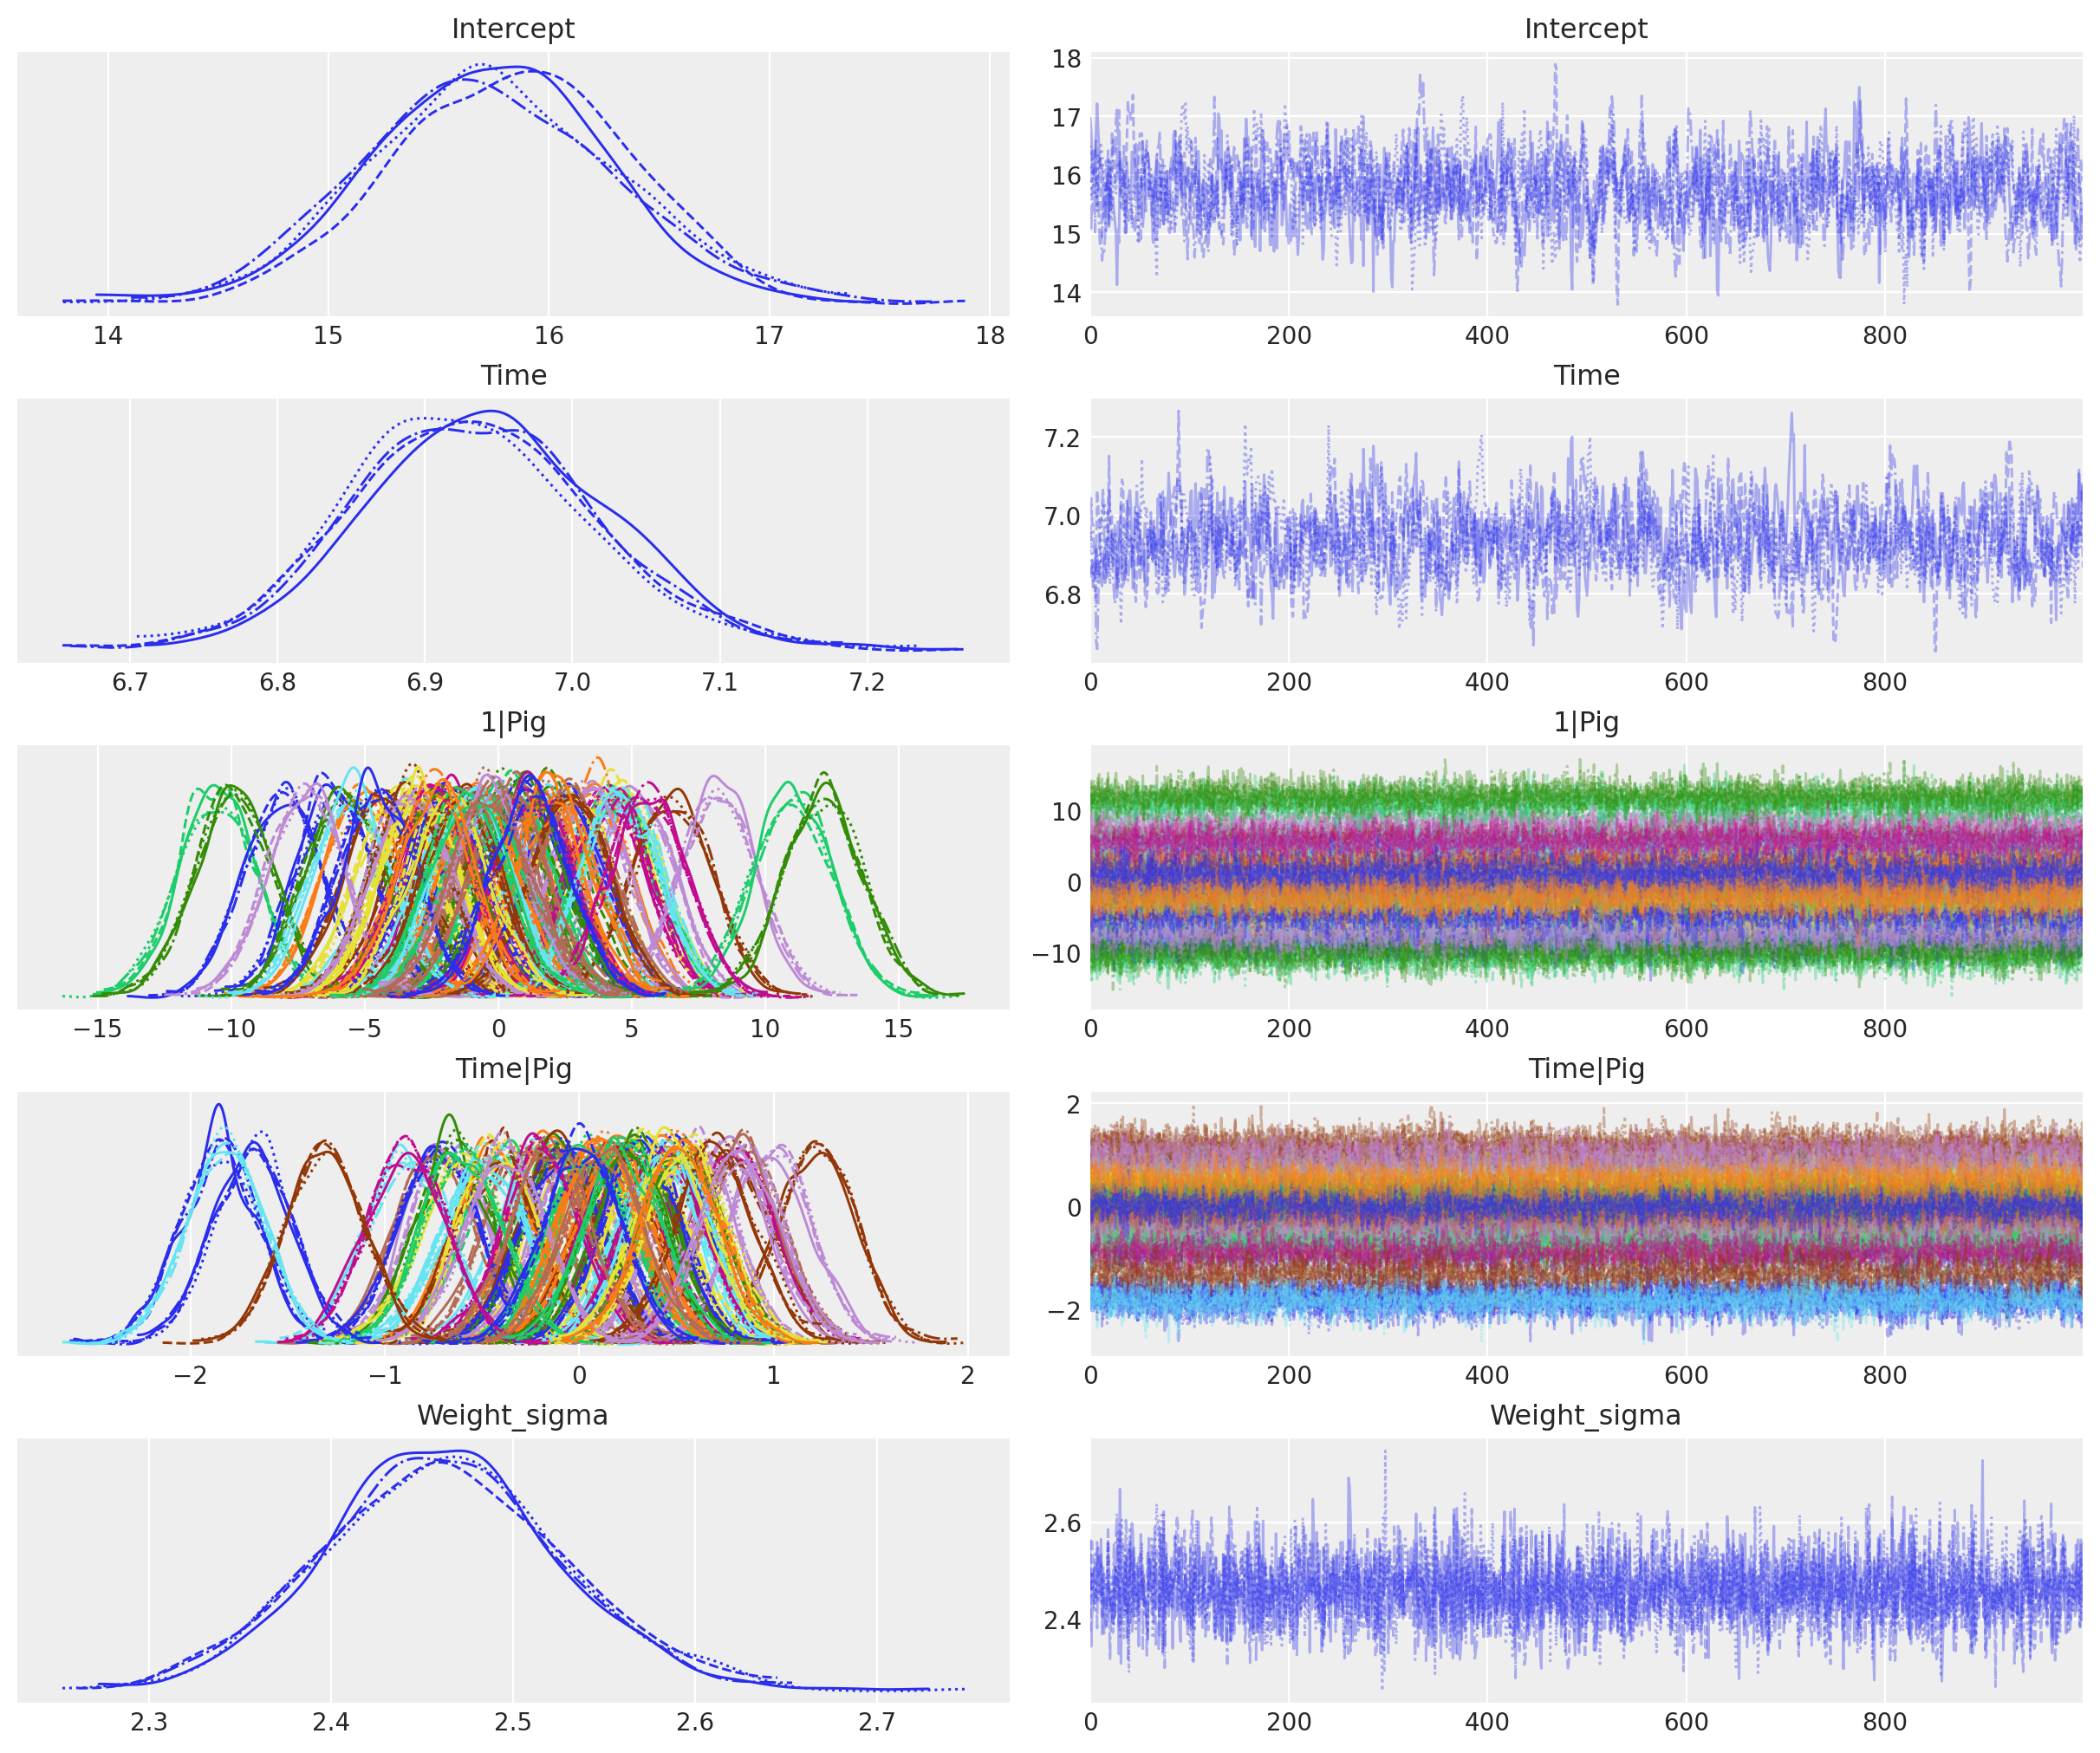

In [21]:
# Plot posteriors
az.plot_trace(
    results,
    var_names=["Intercept", "Time", "1|Pig", "Time|Pig", "Weight_sigma"],
    compact=True,
)

In [22]:
az.summary(results, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "Weight_sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       15.755  0.557  14.760   16.800      0.018    0.013     933.0   
Time             6.934  0.083   6.786    7.097      0.003    0.002     692.0   
1|Pig_sigma      4.532  0.429   3.750    5.318      0.012    0.009    1310.0   
Time|Pig_sigma   0.662  0.061   0.548    0.773      0.002    0.001    1093.0   
Weight_sigma     2.461  0.065   2.344    2.589      0.001    0.001    3991.0   

                ess_tail  r_hat  
Intercept         1526.0   1.01  
Time              1189.0   1.01  
1|Pig_sigma       1805.0   1.00  
Time|Pig_sigma    2291.0   1.00  
Weight_sigma      3208.0   1.00

/var/folders/3m/47824pgj6rl3wf7k8lbrkm_m0000gn/T/ipykernel_21342/3073150734.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  posterior = az.extract_dataset(results)


Text(0.5, 0, 'Time (weeks)')

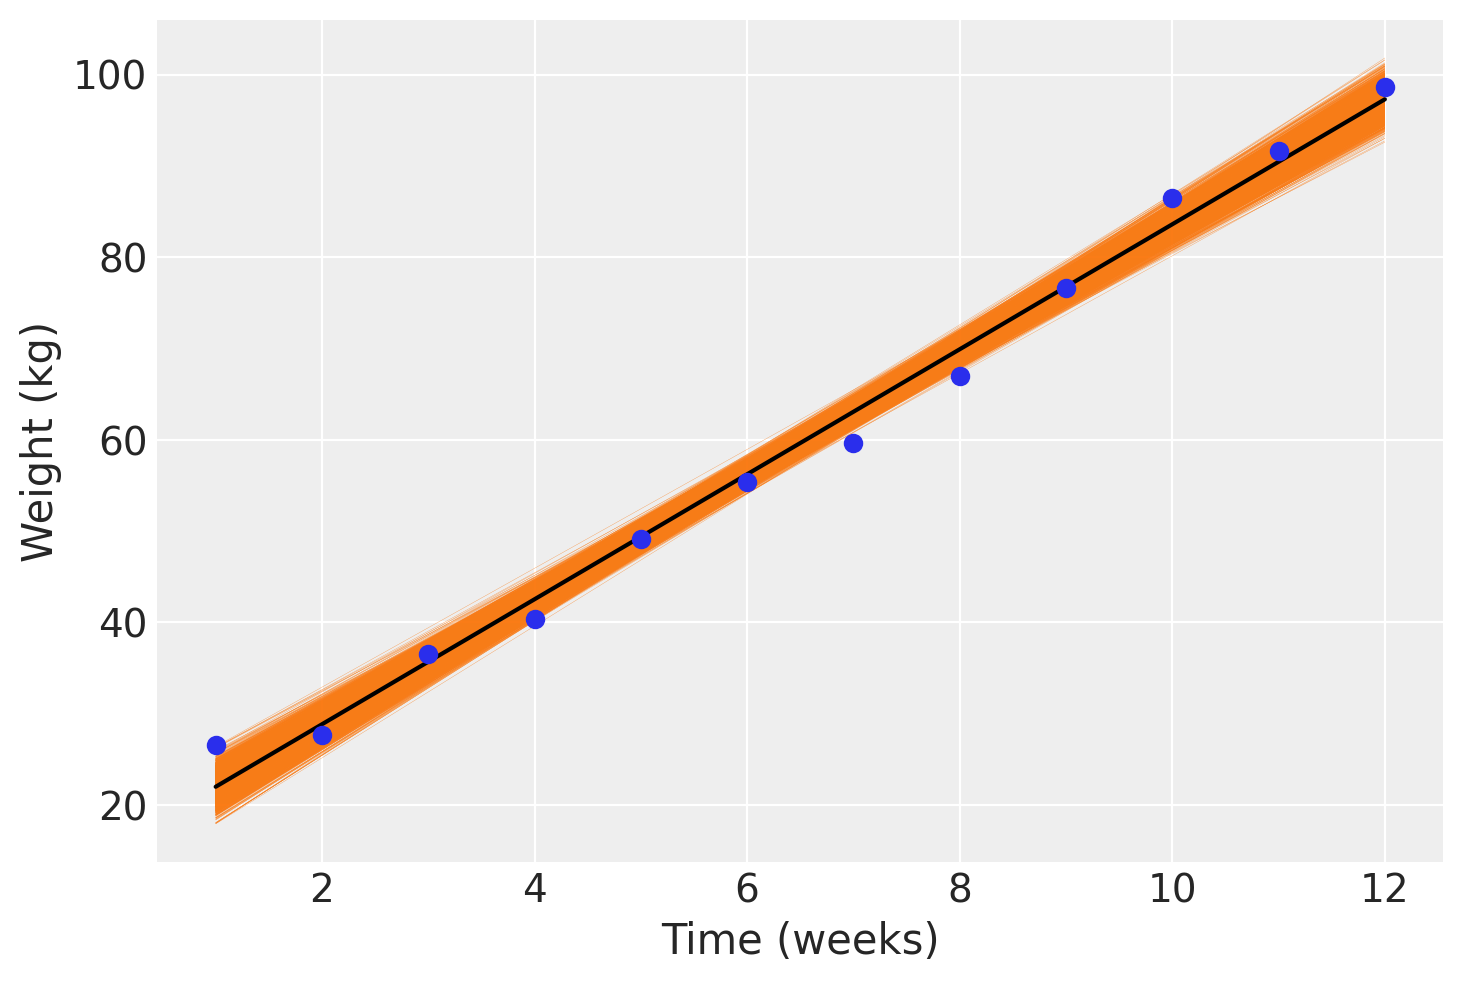

In [24]:
# The ID of the first pig is '4601'
data_0 = data[data["Pig"] == 4601][["Time", "Weight"]]
time = np.array([1, 12])

posterior = az.extract_dataset(results)
intercept_common = posterior["Intercept"]
slope_common = posterior["Time"]

intercept_specific_0 = posterior["1|Pig"].sel(Pig__factor_dim="4601")
slope_specific_0 = posterior["Time|Pig"].sel(Pig__factor_dim="4601")

a = (intercept_common + intercept_specific_0)
b = (slope_common + slope_specific_0)

# make time a DataArray so we can get automatic broadcasting
time_xi = xr.DataArray(time)
plt.plot(time_xi, (a + b * time_xi).T, color="C1", lw=0.1)
plt.plot(time_xi, a.mean() + b.mean() * time_xi, color="black")
plt.scatter(data_0["Time"], data_0["Weight"], zorder=2)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)")

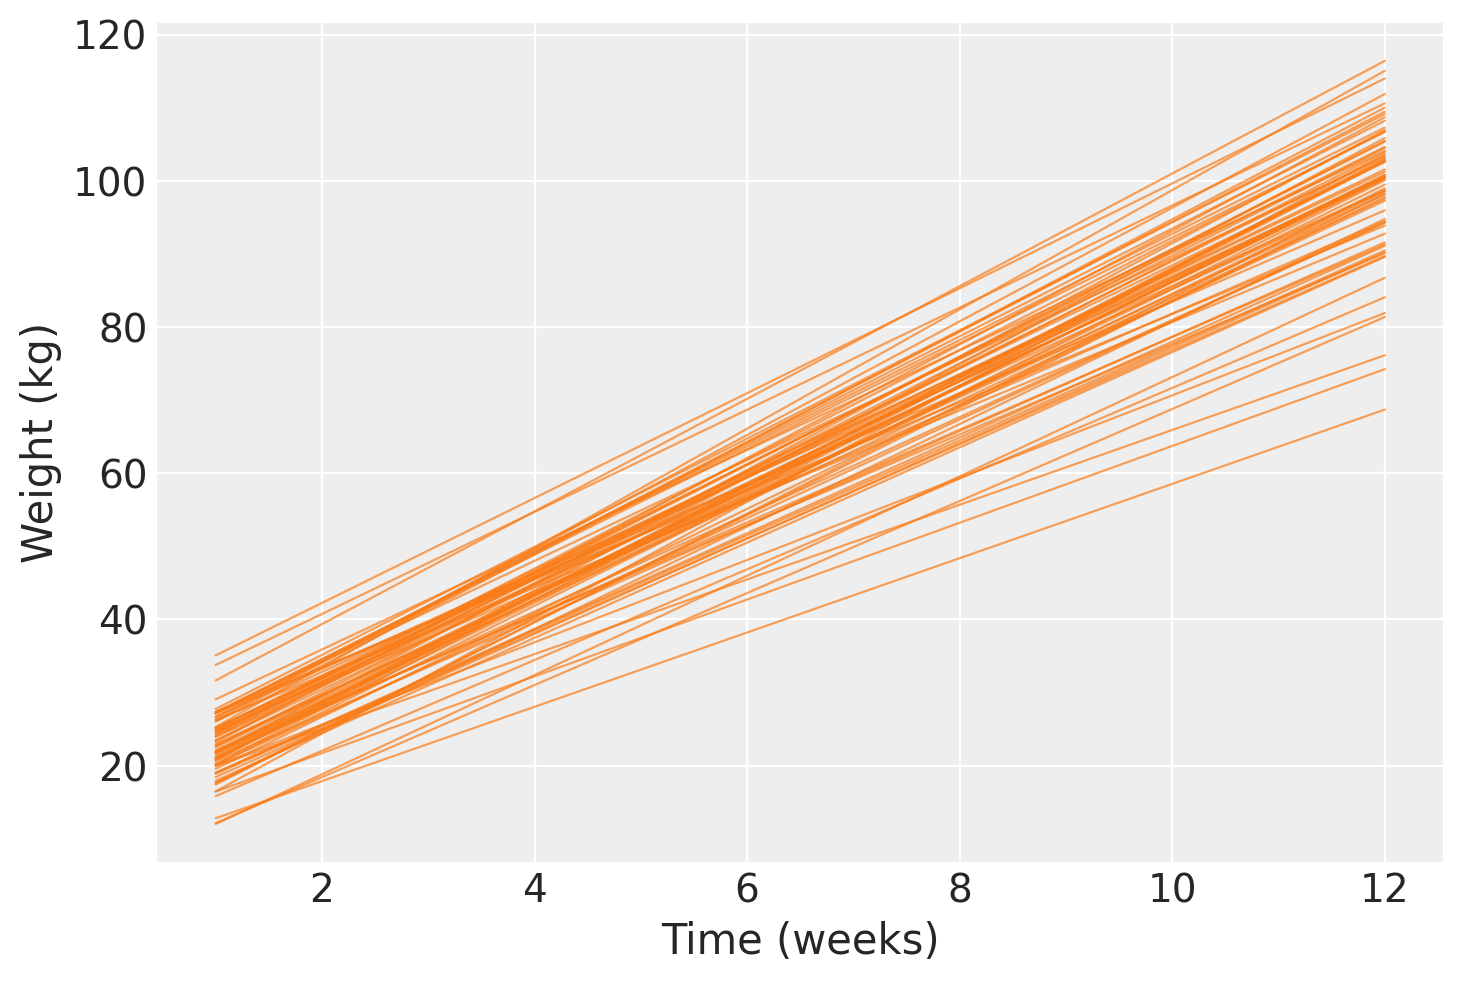

In [25]:
intercept_group_specific = posterior["1|Pig"]
slope_group_specific = posterior["Time|Pig"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean() + slope_group_specific.mean("sample")
time_xi = xr.DataArray(time)
plt.plot(time_xi, (a + b * time_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)");

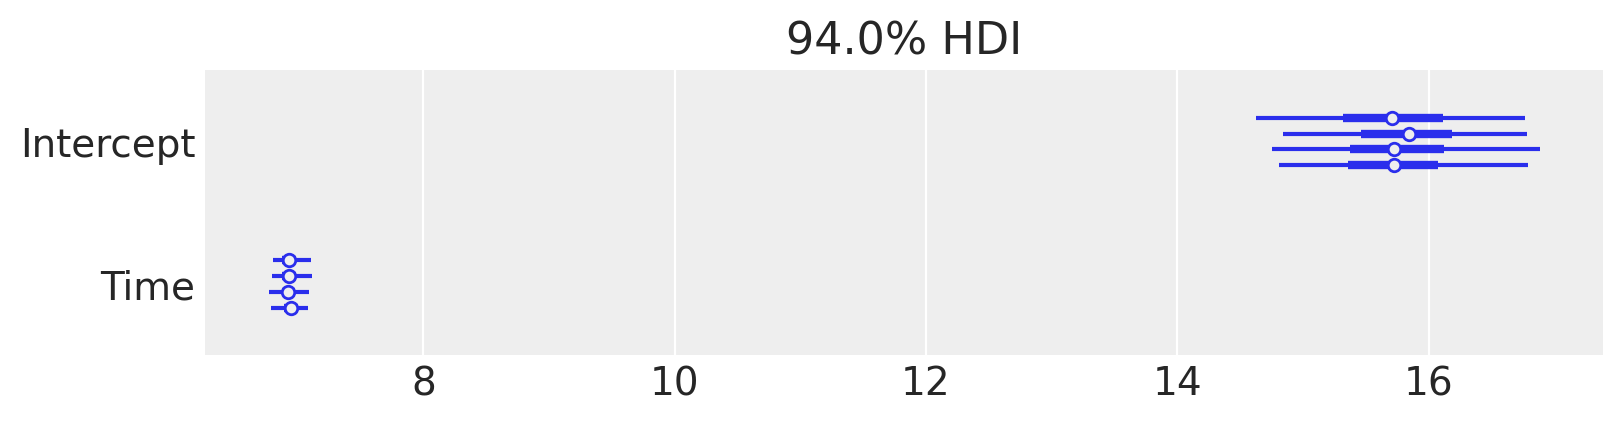

In [26]:
az.plot_forest(
    results,
    var_names=["Intercept", "Time"],
    figsize=(8, 2),
);

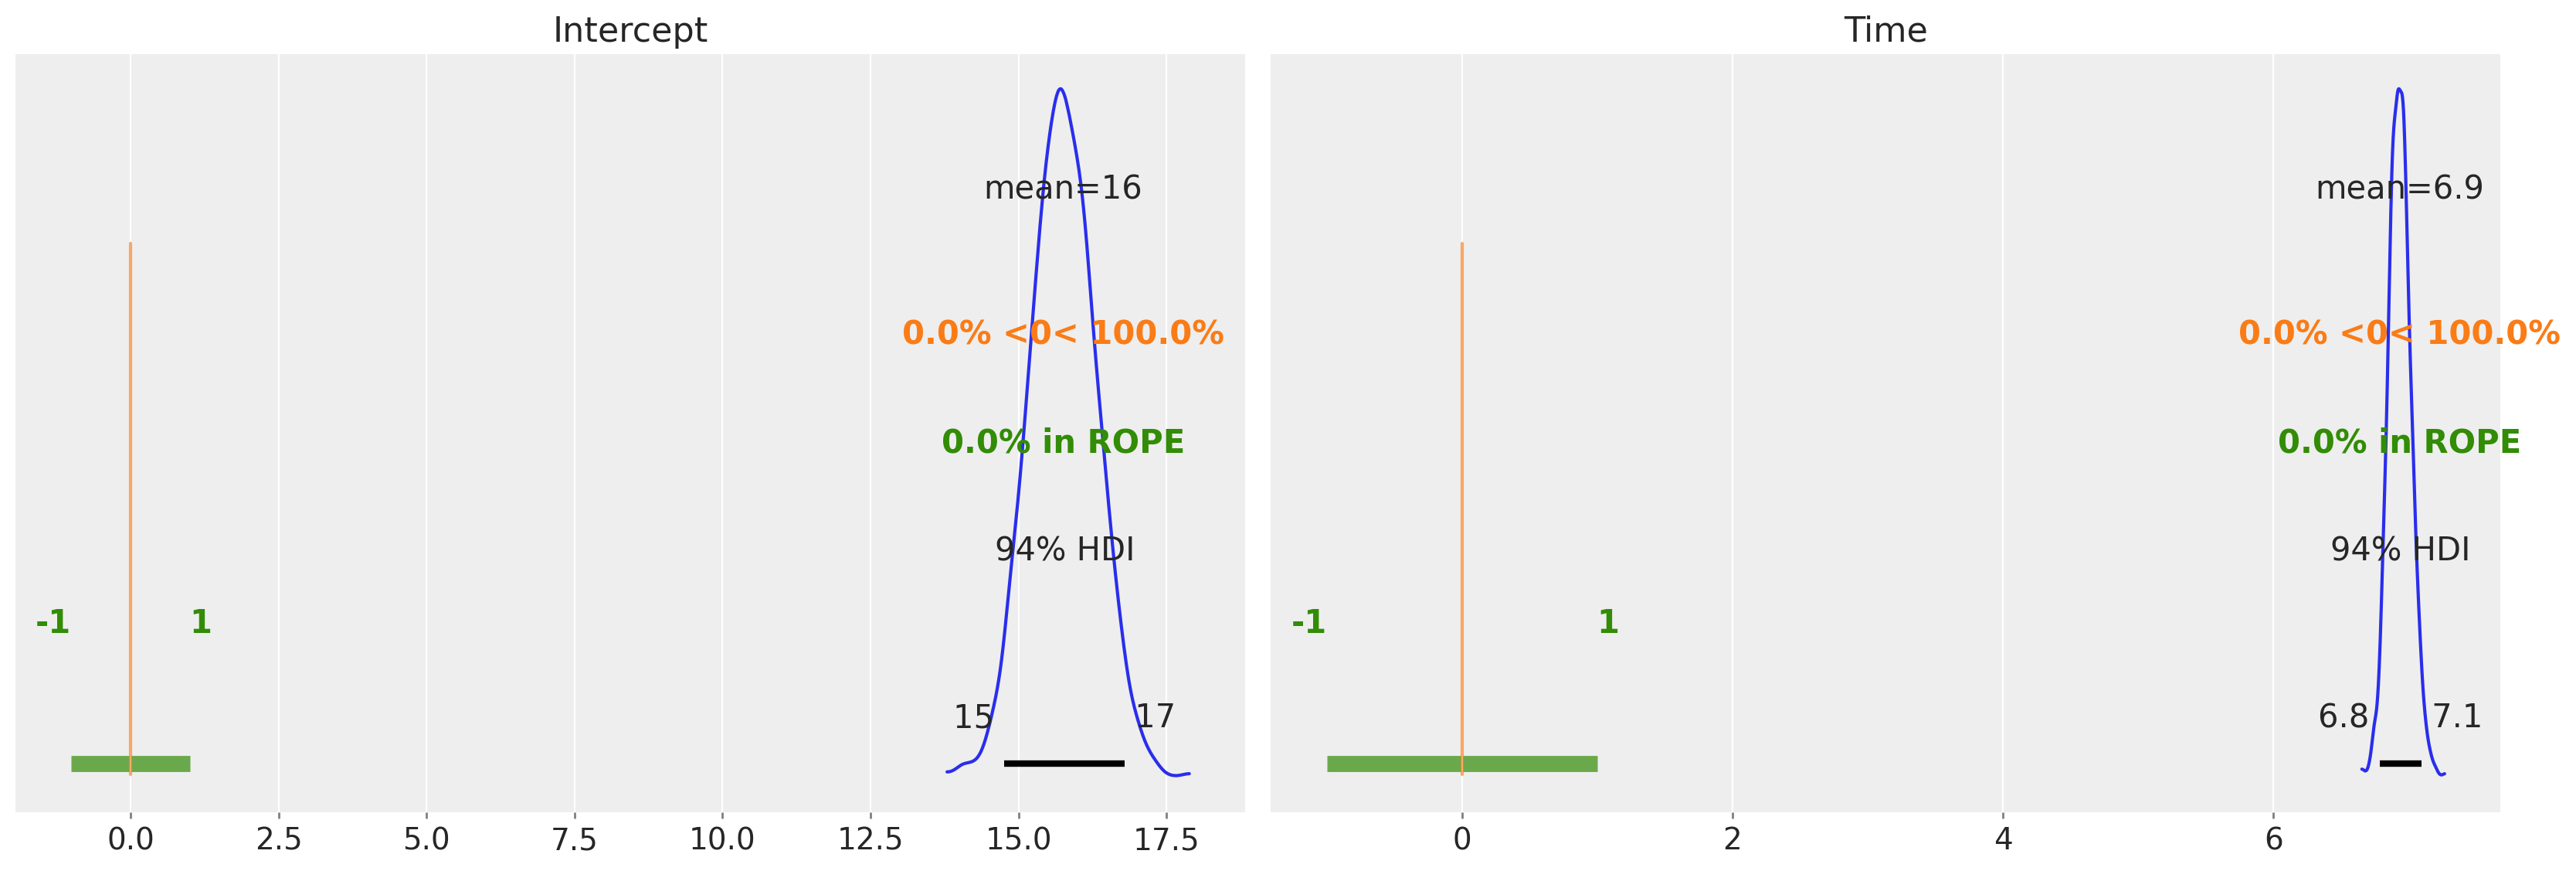

In [27]:
az.plot_posterior(results, var_names=["Intercept", "Time"], ref_val=0, rope=[-1, 1]);